# **Transfer Learning (TL)**

### Usaremos PyTorch para implementar Transfer Learning en un modelo de clasificación. 

Comenzamos importando todas las dependecias necesarias para el correcto funcionamiento del documento.

In [1]:
# Importamos librerías

# Visualización de datos
%matplotlib inline
import matplotlib.pyplot as plt

# Manipulación de matrices e imágenes
import numpy as np
from PIL import Image

# Operaciones en el sistema de archivos
import os

# PyTorch para redes neuronales y optimización
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

# Torchvision para visión artificial y conjuntos de datos
import torchvision
import torchvision.transforms as transforms

# Métricas de evaluación
from sklearn.metrics import confusion_matrix

c:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Cargamos un modelo ya entrenado. En concreto, usaremos el modelo pre-entrenado ResNet-34.

In [2]:
model = torchvision.models.resnet34(pretrained=True)

Ahora creamos una función para poder cargar imágenes y de esta manera poder entrenar y evaluar nuestro modelo.

In [3]:
def load_dataset(data_path):
    '''
    Función para cargar el conjunto de datos utilizando cargadores de entrenamiento y prueba.
    '''
    
    # Cambiar tamaño a 256 x 256, luego recortar al centro a 224x224 (para que coincida con el tamaño de imagen de ResNet)
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Cargar todas las imágenes, aplicándoles la transformación
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    # Dividir en conjuntos de entrenamiento (70%) y prueba (30%)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # Definir un cargador para los datos de entrenamiento que podamos iterar en lotes de 30 imágenes
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=30,
        num_workers=0,
        shuffle=False
    )
    
    # Definir un cargador para los datos de prueba que podamos iterar en lotes de 30 imágenes
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=30,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader


# Ahora cargar las imágenes desde la carpeta de jugadores
data_path = '../../img/jugadores'

# Obtener los cargadores iterativos para los datos de prueba y entrenamiento
train_loader, test_loader = load_dataset(data_path)

# Obtener los nombres de las clases
classes = os.listdir(data_path)
classes.sort()
print('class names:', classes)

class names: ['Cristiano Ronaldo', 'Erling Haaland', 'Lionel Messi', 'Sergio Ramos']


Adaptamos un modelo pre-entrenado para que pueda realizar una tarea específica en nuestro conjunto de datos, aprovechando el conocimiento aprendido por el modelo pre-entrenado en una tarea relacionada.

In [4]:
# Establecer las capas existentes de extracción de características como de solo lectura
for param in model.parameters():
    param.requires_grad = False

# Reemplazar la capa de predicción
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))

# Ahora imprimir el modelo completo, que incluirá las capas de extracción de características del modelo base y nuestra capa de predicción
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Seguimos entrenando y evaluando nuestro modelo.

In [5]:
def train(model, device, train_loader, optimizer, epoch):
    '''
    Función para entrenar el modelo
    '''

    # Establecer el modelo en modo de entrenamiento
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Usar la CPU o GPU según corresponda
        data, target = data.to(device), target.to(device)
        
        # Reiniciar el optimizador
        optimizer.zero_grad()
        
        # Hacer avanzar los datos a través de las capas del modelo
        output = model(data)
        
        # Obtener la pérdida
        loss = loss_criteria(output, target)
        
        # Mantener un total acumulado
        train_loss += loss.item()
        
        # Retropropagar
        loss.backward()
        optimizer.step()
        
        # Imprimir métricas cada 10 lotes para ver progreso
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # Devolver la pérdida promedio para la época
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader):
    '''
    Función para evaluar el modelo
    '''

    # Cambiar el modelo al modo de evaluación (para no retropropagar ni eliminar)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Obtener las clases predichas para este lote
            output = model(data)
            
            # Calcular la pérdida para este lote
            test_loss += loss_criteria(output, target).item()
            
            # Calcular la precisión para este lote
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calcular la pérdida promedio y la precisión total para esta época
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # Devolver la pérdida promedio para la época
    return avg_loss
    
    
# Ahora usamos las funciones de entrenamiento y prueba para entrenar y probar el modelo    

device = "cpu"
if (torch.cuda.is_available()):
    # Si hay GPU disponible, usar cuda (en una CPU, el entrenamiento tomará un tiempo considerable)
    device = "cuda"
print('Training on', device)

# Creamos una instancia de la clase del modelo y asignarla al dispositivo
model = model.to(device)

# Usamos un optimizador "Adam" para ajustar los pesos
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Especificamos los criterios de pérdida
loss_criteria = nn.CrossEntropyLoss()

# Seguimos las métricas en estos arreglos
epoch_nums = []
training_loss = []
validation_loss = []

# Entrenamos durante 10 épocas
epochs = 10
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1


C:\Users\Laura Rodríguez\AppData\Roaming\Python\Python39\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training set [0/70 (0%)] Loss: 1.597702
Training set: Average loss: 1.516734
Validation set: Average loss: 1.456586, Accuracy: 4/30 (13%)

Epoch: 2
Training set [0/70 (0%)] Loss: 1.381872
Training set: Average loss: 1.314860
Validation set: Average loss: 1.487576, Accuracy: 10/30 (33%)

Epoch: 3
Training set [0/70 (0%)] Loss: 1.394055
Training set: Average loss: 1.252819
Validation set: Average loss: 1.392729, Accuracy: 11/30 (37%)

Epoch: 4
Training set [0/70 (0%)] Loss: 1.260126
Training set: Average loss: 1.135056
Validation set: Average loss: 1.249426, Accuracy: 11/30 (37%)

Epoch: 5
Training set [0/70 (0%)] Loss: 1.082077
Training set: Average loss: 1.024092
Validation set: Average loss: 1.151974, Accuracy: 16/30 (53%)

Epoch: 6
Training set [0/70 (0%)] Loss: 0.965276
Training set: Average loss: 0.942336
Validation set: Average loss: 1.098333, Accuracy: 18/30 (60%)

Epoch: 7
Training set [0/70 (0%)] Loss: 0.890652
Training set: Average loss: 0.860776
Validation set: Average loss: 

Visualizamos cómo cambia la pérdida durante el entrenamiento y la validación a lo largo de las épocas del entrenamiento del modelo.

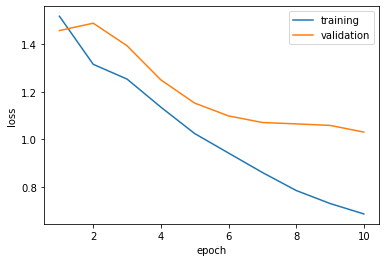

In [6]:
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

También visualizamos la matriz de confusión, mediante la cual podemos evaluar el rendimiento del modelo en la clasificación multiclase. 

Getting predictions from test set...


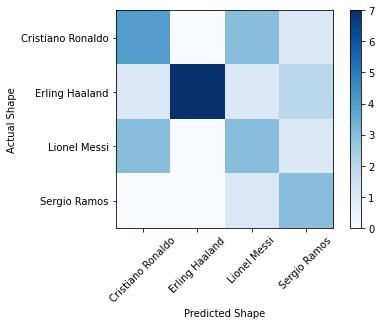

In [7]:
# Establecer el modelo en modo de evaluación
model.eval()

# Obtener predicciones para los datos de prueba y convertirlas en matrices numpy para usar con SciKit-Learn
print("Getting predictions from test set...")
truelabels = []
predictions = []
for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plotear la matriz de confusión
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

En la matriz de confusión podemos observar que generalmente nuestro modelo clasifica bien a nuestros jugadores, pues la diagonal está en colores más oscuros comparados con el resto de la matriz. Sin embargo, vemos que suele confundir a Messi con Ronaldo y viceversa.

El próximo paso es definir la función que nos vaya a predecir el nombre del jugador a partir de la ruta a la imagen que queremos que analice.

In [8]:
def predict_image(classifier, image_path):
    '''
    Función para predecir la clase de una imagen
    '''

    # Establecer el modelo del clasificador en modo de evaluación
    classifier.eval()
    
    # Aplicar las mismas transformaciones que hicimos para las imágenes de entrenamiento
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Cargar la imagen
    image = Image.open(image_path)

    # Preprocesar la imagen
    image_tensor = transformation(image).float()

    # Agregar una dimensión de lote adicional ya que PyTorch trata todas las entradas como lotes
    image_tensor = image_tensor.unsqueeze_(0)

    # Convertir la entrada en una Variable
    input_features = Variable(image_tensor)

    # Predecir la clase de la imagen
    output = classifier(input_features)
    index = output.data.numpy().argmax()

    # Mostrar la imagen
    plt.imshow(image) 
    plt.axis('off')
    plt.show()
    
    return index

Una vez definida dicha función, ponemos a prueba nuestro modelo. En la carpeta `prueba` (dentro de `img`) hay 4 imágenes, una de cada jugdor, diferente a las imágenes que hemos usado para el entrenamiento. Usaremos estas imágenes para ver si nuestro modelo clasifica bien a los jugadores.

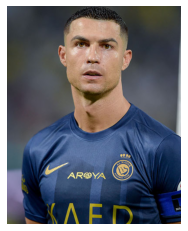

Erling Haaland


In [9]:
index1 = predict_image(model, '../../img/prueba/1.jpg')
print(classes[index1])

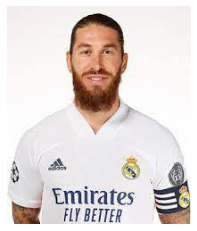

Sergio Ramos


In [10]:
index2 = predict_image(model, '../../img/prueba/2.jpg')
print(classes[index2])

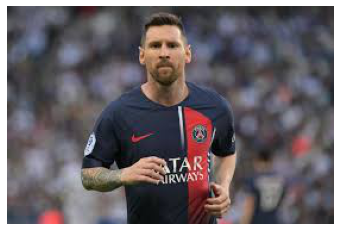

Lionel Messi


In [11]:
index3 = predict_image(model, '../../img/prueba/3.jpg')
print(classes[index3])

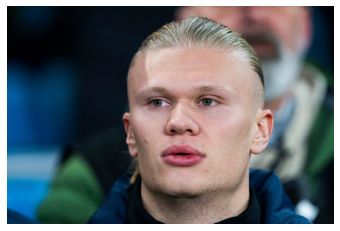

Erling Haaland


In [12]:
index4 = predict_image(model, '../../img/prueba/4.jpg')
print(classes[index4])

Podemos concluir que nuestro modelo no ha hecho una mala predicción. A excepción de Cristiano Ronaldo, que lo ha confundido con Erling Haaland, el resto de jugadores los ha clasificado correctamente.